In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Définition des classes pour les couches du réseau
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.lr = 0.1  # Taux d'apprentissage; essayer de modifier mais à voir

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, valeur_deriv):
        self.dweights = np.dot(self.inputs.T, valeur_deriv)
        self.dbiases = np.sum(valeur_deriv, axis=0, keepdims=True)
        self.dinputs = np.dot(valeur_deriv, self.weights.T)

    def update_params(self):
        self.weights -= self.lr * self.dweights
        self.biases -= self.lr * self.dbiases

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, valeur_deriv):
        self.dinputs = valeur_deriv.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def backward(self, valeur_deriv):
        self.dinputs = np.empty_like(valeur_deriv)
        for index, (single_output, valeur_single_deriv) in enumerate(zip(self.output, valeur_deriv)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, valeur_single_deriv)

class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return np.mean(negative_log_likelihoods)

    def backward(self, valeur_deriv, y_true):
        samples = len(valeur_deriv)
        labels = len(valeur_deriv[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / valeur_deriv
        self.dinputs = self.dinputs / samples


ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
# Chargement des données MNIST
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

print(x_train, y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [5 0 4 ... 5 6 8]


In [ ]:
#Définition du réseau
layer1 = Layer_Dense(784, 128)  # 784 = 28*28
activation1 = Activation_ReLU()
layer2 = Layer_Dense(128, 10)
activation2 = Activation_Softmax()

In [ ]:
#Entrainement du réseau
for epoch in range(1): 
    for batch in range(len(x_train)//100):  
        batch_x = x_train[batch*100:(batch+1)*100]
        batch_y = y_train[batch*100:(batch+1)*100]

        # Propagation avant
        layer1.forward(batch_x)
        activation1.forward(layer1.output)
        layer2.forward(activation1.output)
        activation2.forward(layer2.output)

        # Calcul de la perte
        loss_function = Loss_CategoricalCrossentropy()
        
        loss = loss_function.forward(activation2.output, batch_y)

        # Rétropropagation
        loss_function.backward(activation2.output, batch_y)
        activation2.backward(loss_function.dinputs)
        layer2.backward(activation2.dinputs)
        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)

        # Mise à jour des paramètres
        layer1.update_params()
        layer2.update_params()

    print(f'Epoch {epoch + 1}, Loss: {loss}')

Epoch 1, Loss: 0.3445035974340264


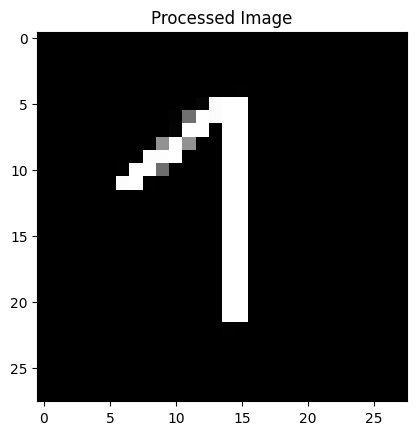

In [8]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    # Décoder explicitement en une image RGB (même si elle sera convertie en niveaux de gris)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [28, 28])
    image = tf.image.rgb_to_grayscale(image)
    
    image = np.array(image, dtype=np.float32) / 255.0
    
    image = 1.0 - image #Faut inverser les couleurs sinon ça marche pas car entrainé sur fond noir
    image = image.reshape(1, 784) 
    return image

image_path = r'C:\Users\arthu\OneDrive\Arthur\Programmation\Python\Reconnaissance_ecriture\Lettres\1.jpg'
image = preprocess_image(image_path)

plt.imshow(image.reshape(28, 28), cmap='gray')
plt.title("Processed Image")
plt.show()

In [6]:
ds = tfds.load('mnist', split='test', as_supervised=True, batch_size=1)
ds = ds.take(10)  # Prendre une seule image pour tester

for image, label in tfds.as_numpy(ds):
    test_image = image[0]  # Récupérer l'image
    test_label = label[0]  # Récup label de l'image

image = test_image.reshape(1, 784) / 255.0 

Probabilités prédites pour chaque classe : [[1.48272440e-06 9.92052166e-01 3.16884887e-03 1.51612464e-03
  5.03864567e-06 3.29936102e-04 2.13970151e-04 1.92565652e-04
  2.46548818e-03 5.43791139e-05]]
Classe prédite : 1


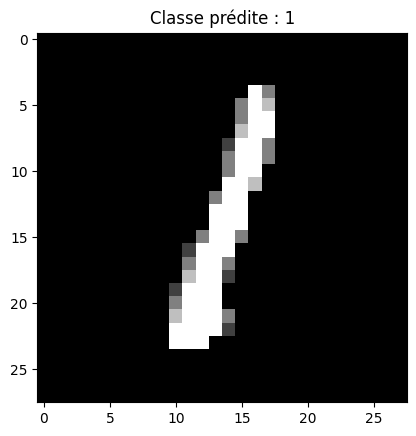

In [7]:
# Propagation avant pour obtenir les prédictions
layer1.forward(image)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# Affichage de la sortie
predicted_probabilities = activation2.output
predicted_class = np.argmax(predicted_probabilities)

print(f"Probabilités prédites pour chaque classe : {predicted_probabilities}")
print(f"Classe prédite : {predicted_class}")

plt.imshow(image.reshape(28, 28), cmap='gray')  # Mise de l'image sous forme de 28x28
plt.title(f'Classe prédite : {predicted_class}')
plt.show()
